In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import plotly.graph_objs as go

In [2]:
filename = "ETH-USD.csv"
df = pd.read_csv(filename)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       731 non-null    object 
 1   Open       731 non-null    float64
 2   High       731 non-null    float64
 3   Low        731 non-null    float64
 4   Close      731 non-null    float64
 5   Adj Close  731 non-null    float64
 6   Volume     731 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 40.1+ KB
None


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)
df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

In [4]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

584
147


In [5]:
look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)


In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(units = 50,return_sequences = True,
        activation='relu',
        input_shape=(look_back,1))
)

model.add(
    LSTM(50,
        activation='relu',
        input_shape=(look_back,1), return_sequences = True)
)

model.add(
    LSTM(50,
        activation='relu',
        input_shape=(look_back,1))
)

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 50
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/50
29/29 [==============================] - 3s 6ms/step - loss: 1697325.3750
Epoch 2/50
29/29 [==============================] - 0s 6ms/step - loss: 337639.3750
Epoch 3/50
29/29 [==============================] - 0s 6ms/step - loss: 36969.6758
Epoch 4/50
29/29 [==============================] - 0s 6ms/step - loss: 33263.3984
Epoch 5/50
29/29 [==============================] - 0s 6ms/step - loss: 30291.6504
Epoch 6/50
29/29 [==============================] - 0s 6ms/step - loss: 34508.3867
Epoch 7/50
29/29 [==============================] - 0s 7ms/step - loss: 35013.4023
Epoch 8/50
29/29 [==============================] - 0s 6ms/step - loss: 36748.6992
Epoch 9/50
29/29 [==============================] - 0s 7ms/step - loss: 30578.0801
Epoch 10/50
29/29 [==============================] - 0s 7ms/step - loss: 35262.7305
Epoch 11/50
29/29 [==============================] - 0s 6ms/step - loss: 26427.1035
Epoch 12/50
29/29 [==============================] - 0s 6ms/step - loss: 38780.640

In [32]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [33]:
close_data = close_data.reshape((-1))
look_back = 5
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)


In [34]:
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = forecast.reshape((-1))

trace1 = go.Scatter(
    x = forecast_dates,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace2, trace3], layout=layout)
fig.show()

In [35]:
adj_close_data = df["Adj Close"].values
adj_close_data = adj_close_data.reshape((-1))
look_back = 5
def predict(num_prediction, model):
    prediction_list = adj_close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
adj_forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)



#--------------------------

adj_close_train = adj_close_data[:split]
adj_close_test = adj_close_data[split:]

adj_close_train = adj_close_train.reshape((-1))
adj_close_test = adj_close_test.reshape((-1))
adj_prediction = adj_forecast.reshape((-1))

trace1 = go.Scatter(
    x = forecast_dates,
    y = adj_close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = adj_prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = adj_close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[ trace2, trace3], layout=layout)
fig.show()

## ADDING ALL INFO INTO A FILE

In [36]:
#get all close prices values with predicted values (for protfolio prediction)
import datetime

indexes = pd.date_range(start='31/12/2021', end='1/30/2022')

newdf = pd.DataFrame(indexes, columns = ["Date"])
newdf["Close"] = forecast
newdf["Adj Close"] = adj_forecast
dffinal = df.loc[:,["Date" ,"Close","Adj Close"]]
dffinal = dffinal.append(newdf)
dffinal['Date'] = pd.to_datetime(dffinal['Date'])
dffinal

,Date,Close,Adj Close
2020-01-01 00:00:00,2020-01-01,130.802002,130.802002
2020-01-02 00:00:00,2020-01-02,127.410179,127.410179
2020-01-03 00:00:00,2020-01-03,134.171707,134.171707
2020-01-04 00:00:00,2020-01-04,135.069366,135.069366
2020-01-05 00:00:00,2020-01-05,136.276779,136.276779
...,...,...,...
26,2022-01-26,3377.897949,3377.897949
27,2022-01-27,3365.340820,3365.340820
28,2022-01-28,3355.089111,3355.089111
29,2022-01-29,3345.929932,3345.929932


In [37]:
dffinal.to_csv("ETHpredict.csv", index = False)

## PORTFOLIO OPTIMIZATION STATS

In [21]:
dffinal = pd.read_csv("ETHpredict.csv")

In [14]:
dffinal.set_axis(dffinal['Date'], inplace=True)
dffinal.drop(columns=["Date"],inplace = True)

In [15]:
#this are the predicted valyes 

dffinal.tail(60)

,Close,Adj Close
Date,,
2021-12-03,4220.706055,4220.706055
2021-12-04,4119.587402,4119.587402
2021-12-05,4198.322754,4198.322754
2021-12-06,4358.737305,4358.737305
2021-12-07,4315.061523,4315.061523
2021-12-08,4439.357910,4439.357910
2021-12-09,4119.815918,4119.815918
2021-12-10,3908.496094,3908.496094
2021-12-11,4084.452393,4084.452393


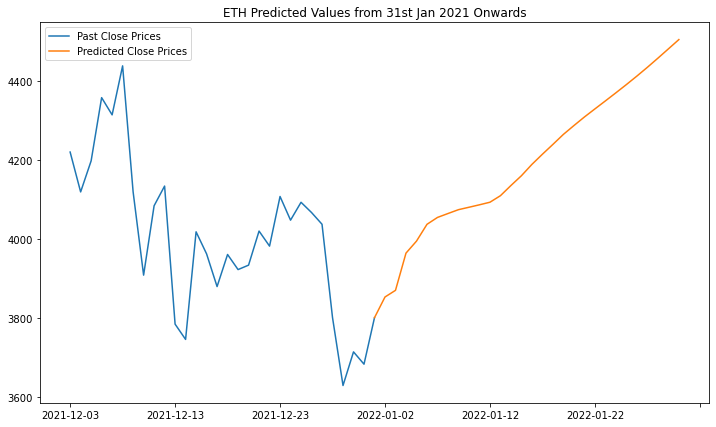

In [89]:
dffinal_close = dffinal["Close"]
predictedvalues = dffinal_close[-30:]

from matplotlib.pyplot import figure
figure(figsize=(12,7))
plt.plot(dffinal_close[-60:-29], label = "Past Close Prices")
plt.plot(predictedvalues, label = "Predicted Close Prices")
plt.xticks([0,10,20,30,40,50,60])
plt.title("ETH Predicted Values from 31st Jan 2021 Onwards")
plt.legend()